# Second order stochastic methods for CryoEM -- OASIS

In [1]:
%load_ext autoreload
%autoreload 2
import site
import sys
import time
import pickle
site.addsitedir('..')
from jax.config import config

config.update("jax_enable_x64", True)

In [2]:
import jax
import mrcfile
from jax.scipy.special import gammaln
from jax import random
from tqdm import tqdm 

import numpy as np
import jax.numpy as jnp
from  matplotlib import pyplot as plt
from src.utils import *
from src.projection import *
from src.interpolate import *
from src.jaxops import *
from src.algorithm import sgd, get_sgd_vol_ops, get_cg_vol_ops
from src.algorithm import conjugate_gradient as cg
from src.algorithm import oasis, oasis_adaptive
from src.datasets import *
from src.noise import estimate_noise, average_radially, estimate_noise_radial
from src.preprocess import *
from src.fsc import calc_fsc

plt.rcParams["figure.figsize"]=6,6

In [ ]:
data_dir = "/gpfs/gibbs/pi/lederman/dge5/CrossValidationCryodrgnSet/"
star_file = "particles_crossvalidation_train_1.star"

params0, imgs0 = load_data(data_dir, star_file, load_imgs = True, fourier = False)

/home/bt387/project/2021_CryoEMSolver7/external/pyem/pyem/star.py:531: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  df[UCSF.IMAGE_INDEX], df[UCSF.IMAGE_PATH] = \
/home/bt387/project/2021_CryoEMSolver7/external/pyem/pyem/star.py:539: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  df[UCSF.IMAGE_ORIGINAL_INDEX], df[UCSF.IMAGE_ORIGINAL_PATH] = \


load_data: number of partcles: 105519


In [ ]:
out_dir = out_dir = '../data/out_dev/'

In [ ]:
nx0 = imgs0.shape[1]
nx_crop = 128 # 64
N = 80000 # 20000
N_px_noise = 48
N_imgs_noise=1000

processed_data = preprocess(imgs0, params0, out_dir, nx_crop = nx_crop, N = N, N_px_noise = N_px_noise, N_imgs_noise = N_imgs_noise)

imgs_f = processed_data["imgs_f"]
pixel_size = processed_data["pixel_size"]
angles = processed_data["angles"]
shifts = processed_data["shifts"]
ctf_params = processed_data["ctf_params"]
idxrand = processed_data["idxrand"]
nx = processed_data["nx"]
x_grid = processed_data["x_grid"]
mask = processed_data["mask"]
sigma_noise = processed_data["sigma_noise"]
N = imgs_f.shape[0]

In [ ]:
plt.imshow(jnp.fft.fftshift(jnp.abs(imgs_f[135].reshape([nx_crop,nx_crop]))));plt.colorbar()

In [ ]:
#del(imgs0)

### Only volume reconstruction for now - SGD vs OASIS

In [ ]:
sigma_noise_est = sigma_noise
sigma_noise = jnp.ones(sigma_noise.shape)
#sigma_noise = sigma_noise_est

In [ ]:
sigma_noise

In [ ]:
jnp.max(sigma_noise_est)/jnp.min(sigma_noise_est)

In [ ]:
# Apply mask to images
mask2d = mask[0].reshape(-1)
imgs_f = imgs_f * mask2d

In [ ]:
key = random.PRNGKey(int(jnp.floor(np.random.rand()*1000)))

In [ ]:
mask0 = jnp.ones(mask.shape)

In [ ]:
idxrand = np.random.permutation(N)
idx1 = idxrand[:N//2]
idx2 = idxrand[N//2:]

In [ ]:
alpha =  1e-9 #1e-5 #1e-9 #1e-9 # 1e-5

slice_obj = Slice(x_grid, mask = mask, interp_method = "nn")
loss_obj = Loss(slice_obj, alpha = alpha)
gradv_obj = GradV(loss_obj)

Use the same datasets, loss, grad, hvp, x0, D0 for SGD, OASIS (and CG)

In [ ]:
grad_func1, loss_func1, hvp_func1 = get_sgd_vol_ops(gradv_obj, loss_obj, angles[idx1], shifts[idx1], ctf_params[idx1], imgs_f[idx1], sigma_noise)
grad_func2, loss_func2, hvp_func2 = get_sgd_vol_ops(gradv_obj, loss_obj, angles[idx2], shifts[idx2], ctf_params[idx2], imgs_f[idx2], sigma_noise)

# No CTF for now
#no_ctf_params = np.zeros(N)
#no_shifts = np.zeros(shifts.shape)

#grad_func1, loss_func1, hvp_func1 = get_sgd_vol_ops(gradv_obj, loss_obj, angles[idx1], shifts[idx1], no_ctf_params[idx1], imgs_f[idx1], sigma_noise)
#grad_func2, loss_func2, hvp_func2 = get_sgd_vol_ops(gradv_obj, loss_obj, angles[idx2], shifts[idx2], no_ctf_params[idx2], imgs_f[idx2], sigma_noise)

key, subkey = random.split(key)
x0 = random.normal(subkey, [nx,nx,nx], dtype=jnp.complex128)


In [ ]:
n_epochs = 20 #2000 * 4 
batch_sz = 100
n_batch = N//2 / batch_sz

zD01z = np.zeros([nx,nx,nx])
zD02z = np.zeros([nx,nx,nx])

for i in tqdm(range(n_epochs)):
    key, subkey = random.split(key)
    idx_batches = np.array_split(random.permutation(subkey, N//2), n_batch)
    
    for idx in idx_batches:
        key, subkey = random.split(key)
   
        z = random.rademacher(subkey, [nx,nx,nx], dtype=x0.dtype)
        #z = random.rademacher(subkey, [nx,nx,nx])
    
        zD01z += z * hvp_func1(x0, z, idx)
        zD02z += z * hvp_func2(x0, z, idx)
    
D01 = jnp.array(zD01z/(n_epochs * n_batch))
D02 = jnp.array(zD02z/(n_epochs * n_batch))

9.999999999998826e-10
0.07925219848209362
79252198.48210293


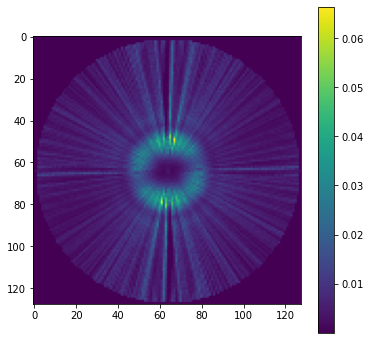

In [27]:
plt.imshow(jnp.fft.fftshift(jnp.abs(D01[0,:,:]))); plt.colorbar()
print(jnp.min(jnp.abs(D01)))
print(jnp.max(jnp.abs(D01)))
print(jnp.max(jnp.abs(D01))/jnp.min(jnp.abs(D01)))

In [28]:
print(jnp.max(jnp.abs(D01)))
print(jnp.max(jnp.abs(D02))) 
print(jnp.max(jnp.abs(D01-D02)))

0.07925219848209362
0.08044145654202133
0.004713187043719605


In [ ]:
# Compute the Hessian diagonals exactly (valid for NN interpolation) - do it in batches

batch_sz = 100
n_batch = N//2 / batch_sz
idx_batches = np.array_split(np.arange(N//2), n_batch)
ones = jnp.ones(x0.shape, dtype=jnp.complex128)

D1 = np.zeros([nx,nx,nx], dtype=np.complex128)
D2 = np.zeros([nx,nx,nx], dtype=np.complex128)
for idx in idx_batches:
    D1 += hvp_func1(x0, ones, idx)
    D2 += hvp_func2(x0, ones, idx)    
    
D1 = jnp.array(D1/n_batch)
D2 = jnp.array(D2/n_batch)


1.0000000000000073e-09
0.07925219848209386
79252198.48209329


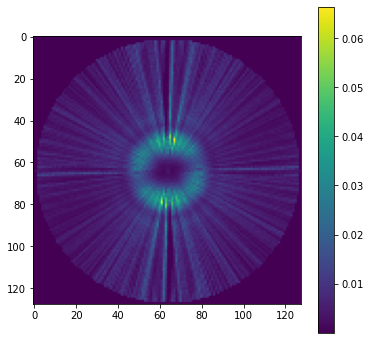

In [29]:
plt.imshow(jnp.fft.fftshift(jnp.abs(D1[0,:,:]))); plt.colorbar()
print(jnp.min(jnp.abs(D1)))
print(jnp.max(jnp.abs(D1)))
print(jnp.max(jnp.abs(D1))/jnp.min(jnp.abs(D1)))

In [30]:
err = jnp.max(jnp.abs(D1-D01)/jnp.max(jnp.abs(D1)))
print(f"Error = {err}")

Error = 9.784225656993358e-15


#### Sanity check that the Hessian is indeed diagonal for NN interpolation and that I'm computing it correctly

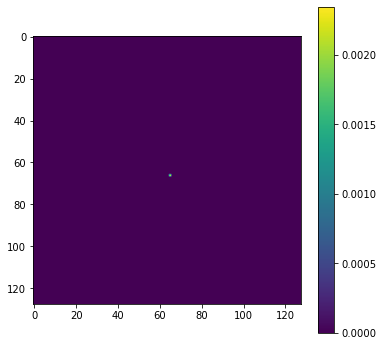

In [31]:
ei = jnp.zeros([nx,nx,nx], dtype = jnp.complex128)
ei = ei.at[0,2,1].set(1)
hvp = hvp_func1(x0, ei, [4123, 1, 0, 6])
plt.imshow(jnp.fft.fftshift(jnp.abs(hvp[0,:,:]))); plt.colorbar()

In [32]:
assert(jnp.abs(hvp[0,2,1] - jnp.sum(hvp)) == 0)

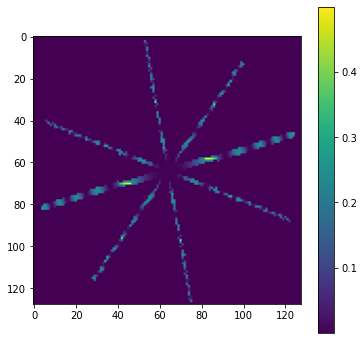

In [33]:
ones = jnp.ones(x0.shape, dtype=jnp.complex128)
hvp_diag = hvp_func1(x0, ones, [4123, 1, 0, 6])
plt.imshow(jnp.fft.fftshift(jnp.abs(hvp_diag[0,:,:]))); plt.colorbar()

In [34]:
assert(jnp.abs(hvp[0,2,1] - hvp_diag[0,2,1]) == 0)

In [35]:
key, subkey1, subkey2 = random.split(key, 3)
x01 = random.normal(subkey1, [nx,nx,nx], dtype = jnp.complex128)
x02 = random.normal(subkey2, [nx,nx,nx], dtype = jnp.complex128)


#### SGD

In [116]:
N_epochs = 10
batch_size = 1000
step_size =  1e0 #1e1 #1e-4 #1e-1 #1e-5 #1e-2 #1000000 # 1e-3

# Step sizes (empirically found, i.e. the largest that doesn't lead to loss exploding): 

#### Tri interpolation, no sigma_noise, lam=1e-9

# 10k imgs, 64px:
#   no precon: 1e1
#   precon: 1e-1

# 40k imgs, 128px:
#  no precon: 1e1
#  precon: 1e-1 (with D1, D2 computed as for NN -- similar to OASIS)


### NN interpolation, no sigma_noise, lam=1e-9

# 10k imgs, 64px:
#   no precon: 1e1
#   precon: 1e-1

# 40k imgs, 128px:
#  no precon: 1e0
#  precon: 

In [117]:
P1 = None
#P1 = 1/D1

v_rec1, loss_rec1, grad_rec1 = sgd(grad_func1, loss_func1, N//2, x01, step_size, N_epochs, batch_size, P = P1, verbose=True, iter_display=1)


Epoch 1/10 

100%|██████████| 40/40 [00:29<00:00,  1.37it/s, grad=1.944e+01, loss=7.844e+08]


  |Grad| = 2.008e+01
  Loss = 7.864e+08
Epoch 2/10 

100%|██████████| 40/40 [00:29<00:00,  1.37it/s, grad=1.596e+01, loss=7.853e+08]


  |Grad| = 1.653e+01
  Loss = 7.836e+08
Epoch 3/10 

100%|██████████| 40/40 [00:29<00:00,  1.37it/s, grad=1.313e+01, loss=7.822e+08]


  |Grad| = 1.468e+01
  Loss = 7.824e+08
Epoch 4/10 

100%|██████████| 40/40 [00:29<00:00,  1.37it/s, grad=1.275e+01, loss=7.812e+08]


  |Grad| = 1.316e+01
  Loss = 7.816e+08
Epoch 5/10 

100%|██████████| 40/40 [00:29<00:00,  1.37it/s, grad=1.270e+01, loss=7.823e+08]


  |Grad| = 1.236e+01
  Loss = 7.812e+08
Epoch 6/10 

100%|██████████| 40/40 [00:29<00:00,  1.37it/s, grad=1.149e+01, loss=7.822e+08]


  |Grad| = 1.210e+01
  Loss = 7.808e+08
Epoch 7/10 

100%|██████████| 40/40 [00:29<00:00,  1.37it/s, grad=1.057e+01, loss=7.779e+08]


  |Grad| = 1.209e+01
  Loss = 7.806e+08
Epoch 8/10 

100%|██████████| 40/40 [00:29<00:00,  1.37it/s, grad=1.349e+01, loss=7.783e+08]


  |Grad| = 1.183e+01
  Loss = 7.804e+08
Epoch 9/10 

100%|██████████| 40/40 [00:29<00:00,  1.37it/s, grad=1.129e+01, loss=7.841e+08]


  |Grad| = 1.185e+01
  Loss = 7.802e+08
Epoch 10/10 

100%|██████████| 40/40 [00:29<00:00,  1.37it/s, grad=1.260e+01, loss=7.789e+08]


  |Grad| = 1.190e+01
  Loss = 7.801e+08


In [118]:
P2 = None
#P2 = 1/D2

v_rec2, loss_rec2, grad_rec2 = sgd(grad_func2, loss_func2, N//2, x02, step_size, N_epochs, batch_size, P = P2, verbose=True, iter_display=1)


Epoch 1/10 

100%|██████████| 40/40 [00:29<00:00,  1.38it/s, grad=1.735e+01, loss=7.856e+08]


  |Grad| = 2.053e+01
  Loss = 7.851e+08
Epoch 2/10 

100%|██████████| 40/40 [00:29<00:00,  1.37it/s, grad=1.558e+01, loss=7.802e+08]


  |Grad| = 1.652e+01
  Loss = 7.823e+08
Epoch 3/10 

100%|██████████| 40/40 [00:29<00:00,  1.37it/s, grad=1.446e+01, loss=7.807e+08]


  |Grad| = 1.448e+01
  Loss = 7.811e+08
Epoch 4/10 

100%|██████████| 40/40 [00:29<00:00,  1.37it/s, grad=1.236e+01, loss=7.790e+08]


  |Grad| = 1.309e+01
  Loss = 7.804e+08
Epoch 5/10 

100%|██████████| 40/40 [00:29<00:00,  1.37it/s, grad=1.314e+01, loss=7.804e+08]


  |Grad| = 1.222e+01
  Loss = 7.799e+08
Epoch 6/10 

100%|██████████| 40/40 [00:29<00:00,  1.37it/s, grad=1.087e+01, loss=7.807e+08]


  |Grad| = 1.188e+01
  Loss = 7.795e+08
Epoch 7/10 

100%|██████████| 40/40 [00:29<00:00,  1.37it/s, grad=1.284e+01, loss=7.817e+08]


  |Grad| = 1.224e+01
  Loss = 7.793e+08
Epoch 8/10 

100%|██████████| 40/40 [00:29<00:00,  1.37it/s, grad=1.189e+01, loss=7.838e+08]


  |Grad| = 1.178e+01
  Loss = 7.791e+08
Epoch 9/10 

100%|██████████| 40/40 [00:29<00:00,  1.37it/s, grad=1.147e+01, loss=7.786e+08]


  |Grad| = 1.193e+01
  Loss = 7.789e+08
Epoch 10/10 

100%|██████████| 40/40 [00:29<00:00,  1.37it/s, grad=1.079e+01, loss=7.761e+08]


  |Grad| = 1.211e+01
  Loss = 7.788e+08


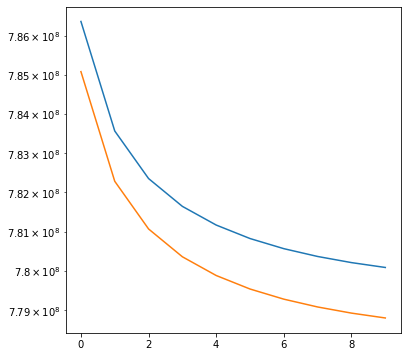

In [119]:
plt.semilogy(loss_rec1)
plt.semilogy(loss_rec2)

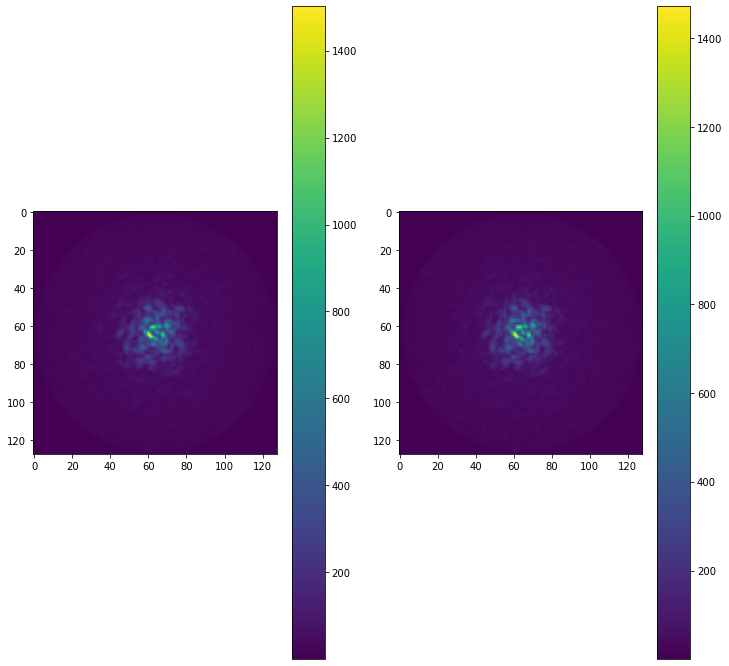

In [157]:
plt.rcParams["figure.figsize"]=12, 12

plt.subplot(1,2,1)
mip_z(np.fft.fftshift(np.imag(v_rec1))); plt.colorbar()

plt.subplot(1,2,2)
mip_z(np.fft.fftshift(np.imag(v_rec2))); plt.colorbar()

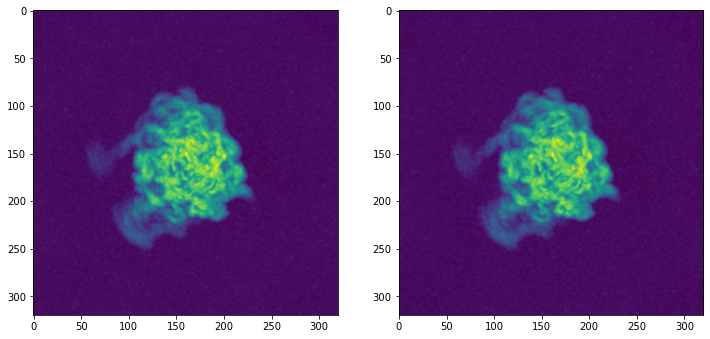

In [121]:
v_rec_l1, _ = rescale_larger_grid(v_rec1, x_grid, nx0)
vr_sgd1 = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(v_rec_l1)))

v_rec_l2, _ = rescale_larger_grid(v_rec2, x_grid, nx0)
vr_sgd2 = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(v_rec_l2)))

plt.subplot(1,2,1)
mip_z(vr_sgd1)
#plt.colorbar()

plt.subplot(1,2,2)
mip_z(vr_sgd2)
#plt.colorbar()

plt.rcParams["figure.figsize"]=6, 6


In [122]:
with mrcfile.new(f"{out_dir}/v_rec_sgd1.mrc", overwrite=True) as mrc:
    mrc.set_data(vr_sgd1.astype(np.float32))
    
with mrcfile.new(f"{out_dir}/v_rec_sgd2.mrc", overwrite=True) as mrc:
    mrc.set_data(vr_sgd2.astype(np.float32))   

Text(0.5, 1.0, 'FSC')

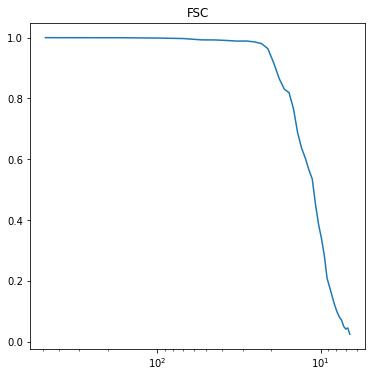

In [123]:
res, fsc_sgd, shell_points = calc_fsc(v_rec1, v_rec2, [1, nx_crop])
res_angs = nx0 * pixel_size[0]/res
plt.semilogx(res_angs, fsc_sgd)
plt.gca().invert_xaxis()
plt.title("FSC")

In [130]:
print(fsc_sgd[21])
print(fsc_sgd[22])
print(res_angs[21])
print(res_angs[22])

0.5354898572938636
0.45289939879582325
11.256987574153078
10.75667701530183


#### OASIS

In [135]:
N_epoch = 10 #30
beta2 = 1 #0.99
eta0 = 1e-2 #1e-2 # 1e-3 #1e-5 #0.0001 #0.1/0.001/0.01/0.15
batch_size = 1000
alpha = 0 #1e-7 

D0bad = jnp.array(np.random.randn(*D01.shape))



#### Tri interpolation, no sigma_noise, lam=1e-9

# 10k imgs, 64px:
#  1e-1 (*0.5 or not depending on beta2)

# 40k imgs, 128px:
#  1e-1 (for alpha 1e-9, D1 D2 calculated as for NN interpolation)

# On the big dataset, D1 D2 as calculated for NN interpolation seem better than the ones obtained 
# using Hutchinson's method with 20 epochs.


#### NN interpolation, no sigma_noise, lam=1e-9

# 10k imgs, 64px:
#   1e-1

# 40k imgs, 128px:
#   1e-2

### Observation: setting beta2 != 1 (e.g. 0.99) can cause the loss to jump and the solution to have amplified noise (for Tri. I didn't try this for NN since the diagonal of the Hessian is the Hessian)

In [136]:
key, subkey = random.split(key)

v_rec_o1, loss_o1 = oasis(subkey, loss_func1, grad_func1, hvp_func1, x01, eta0, D1, beta2, alpha, N_epoch, batch_size = batch_size, N = N//2, iter_display = 1)


Epoch 1/10


100%|██████████| 40/40 [00:44<00:00,  1.11s/it, loss=7.860e+08]


  Loss =  7.876e+08
Epoch 2/10


100%|██████████| 40/40 [00:44<00:00,  1.11s/it, loss=7.809e+08]


  Loss =  7.831e+08
Epoch 3/10


100%|██████████| 40/40 [00:44<00:00,  1.11s/it, loss=7.815e+08]


  Loss =  7.811e+08
Epoch 4/10


100%|██████████| 40/40 [00:44<00:00,  1.11s/it, loss=7.768e+08]


  Loss =  7.802e+08
Epoch 5/10


100%|██████████| 40/40 [00:44<00:00,  1.11s/it, loss=7.822e+08]


  Loss =  7.798e+08
Epoch 6/10


100%|██████████| 40/40 [00:44<00:00,  1.12s/it, loss=7.786e+08]


  Loss =  7.797e+08
Epoch 7/10


100%|██████████| 40/40 [00:44<00:00,  1.11s/it, loss=7.808e+08]


  Loss =  7.796e+08
Epoch 8/10


100%|██████████| 40/40 [00:44<00:00,  1.11s/it, loss=7.790e+08]


  Loss =  7.795e+08
Epoch 9/10


100%|██████████| 40/40 [00:44<00:00,  1.11s/it, loss=7.795e+08]


  Loss =  7.795e+08
Epoch 10/10


100%|██████████| 40/40 [00:44<00:00,  1.11s/it, loss=7.823e+08]


  Loss =  7.795e+08


In [137]:
key, subkey = random.split(key)

v_rec_o2, loss_o2 = oasis(subkey, loss_func2, grad_func2, hvp_func2, x02, eta0, D2, beta2, alpha, N_epoch, batch_size = batch_size, N = N//2, iter_display = 1)


Epoch 1/10


100%|██████████| 40/40 [00:44<00:00,  1.12s/it, loss=7.893e+08]


  Loss =  7.864e+08
Epoch 2/10


100%|██████████| 40/40 [00:44<00:00,  1.12s/it, loss=7.804e+08]


  Loss =  7.819e+08
Epoch 3/10


100%|██████████| 40/40 [00:44<00:00,  1.11s/it, loss=7.778e+08]


  Loss =  7.799e+08
Epoch 4/10


100%|██████████| 40/40 [00:44<00:00,  1.12s/it, loss=7.787e+08]


  Loss =  7.790e+08
Epoch 5/10


100%|██████████| 40/40 [00:44<00:00,  1.11s/it, loss=7.760e+08]


  Loss =  7.786e+08
Epoch 6/10


100%|██████████| 40/40 [00:44<00:00,  1.11s/it, loss=7.757e+08]


  Loss =  7.784e+08
Epoch 7/10


100%|██████████| 40/40 [00:44<00:00,  1.11s/it, loss=7.754e+08]


  Loss =  7.783e+08
Epoch 8/10


100%|██████████| 40/40 [00:44<00:00,  1.12s/it, loss=7.795e+08]


  Loss =  7.783e+08
Epoch 9/10


100%|██████████| 40/40 [00:44<00:00,  1.11s/it, loss=7.793e+08]


  Loss =  7.782e+08
Epoch 10/10


100%|██████████| 40/40 [00:44<00:00,  1.12s/it, loss=7.766e+08]


  Loss =  7.782e+08


In [138]:
key, subkey = random.split(key)

#v_rec_oa1, loss_oa1 = oasis_adaptive(subkey, loss_func1, grad_func1, hvp_func1, x0, eta0, D1, beta2, alpha, N_epoch, batch_size = batch_size, N = N//2, iter_display = 1)


In [139]:
key, subkey = random.split(key)

#v_rec_oa2, loss_oa2 = oasis_adaptive(subkey, loss_func2, grad_func2, hvp_func2, x0, eta0, D2, beta2, alpha, N_epoch, batch_size = batch_size, N = N//2, iter_display = 1)


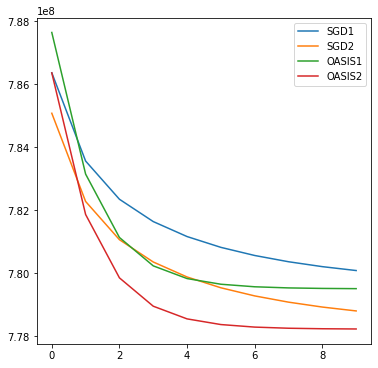

In [182]:
plt.plot(loss_rec1)
plt.plot(loss_rec2)
plt.plot(loss_o1)
plt.plot(loss_o2)
#plt.plot(loss_oa1)
#plt.plot(loss_oa2)
plt.legend(["SGD1", "SGD2", "OASIS1", "OASIS2", "OASIS_a1", "OASIS_a2"])


In [188]:
# Some imag parts explode, clip them 
how_many = jnp.sum(jnp.abs(v_rec_o2) > jnp.max(jnp.abs(v_rec_o1)))
print(how_many)
v_rec_o2a = v_rec_o2.at[jnp.abs(v_rec_o2) > jnp.max(jnp.abs(v_rec_o1))].set(0)

4


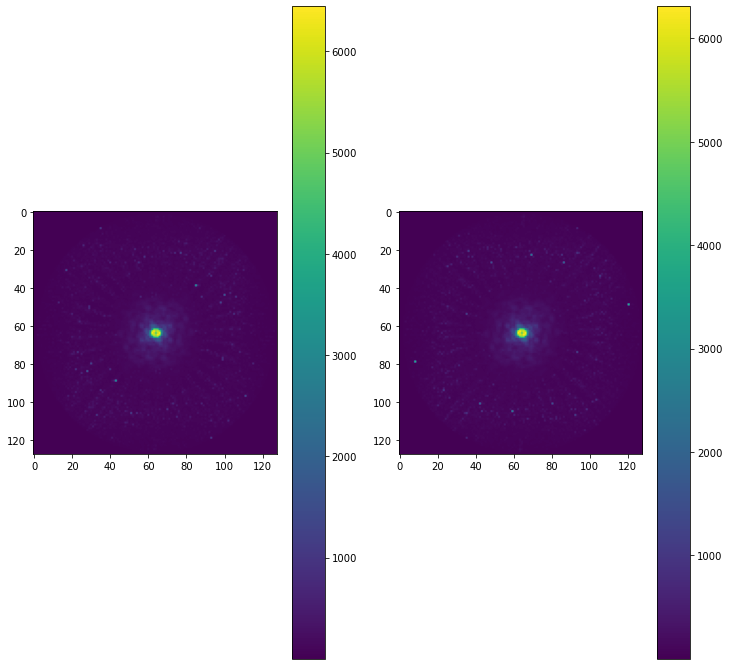

In [190]:
plt.rcParams["figure.figsize"]= 12, 12

plt.subplot(1,2,1)
mip_z(np.fft.fftshift(np.abs(v_rec_o1))); plt.colorbar()

plt.subplot(1,2,2)
mip_z(np.fft.fftshift(np.abs(v_rec_o2a))); plt.colorbar()


In [191]:
#plt.rcParams["figure.figsize"]= 12, 12

#plt.subplot(1,2,1)
#mip_z(np.fft.fftshift(np.real(v_rec_oa1))); plt.colorbar()

#plt.subplot(1,2,2)
#mip_z(np.fft.fftshift(np.abs(v_rec_oa2))); plt.colorbar()


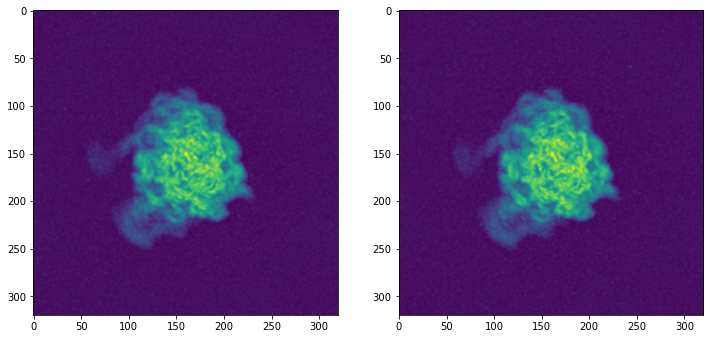

In [192]:
v_rec_ol1, _ = rescale_larger_grid(v_rec_o1, x_grid, nx0)
vr_o1 = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(v_rec_ol1)))

v_rec_ol2, _ = rescale_larger_grid(v_rec_o2a, x_grid, nx0)
vr_o2 = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(v_rec_ol2)))

plt.subplot(1,2,1)
mip_z(vr_o1)
#plt.colorbar()

plt.subplot(1,2,2)
mip_z(vr_o2)
#plt.colorbar()

plt.rcParams["figure.figsize"]=6, 6


In [193]:
with mrcfile.new(f"{out_dir}/v_rec_o1.mrc", overwrite=True) as mrc:
    mrc.set_data(vr_o1.astype(np.float32))
    
with mrcfile.new(f"{out_dir}/v_rec_o2.mrc", overwrite=True) as mrc:
    mrc.set_data(vr_o2.astype(np.float32))   

Text(0.5, 1.0, 'FSC')

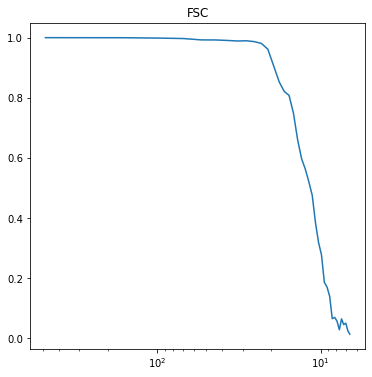

In [194]:
res, fsc_o, shell_points = calc_fsc(v_rec_o1, v_rec_o2a, [1, nx_crop])
res_angs = nx0 * pixel_size[0]/res
plt.semilogx(res_angs, fsc_o)
plt.gca().invert_xaxis()
plt.title("FSC")

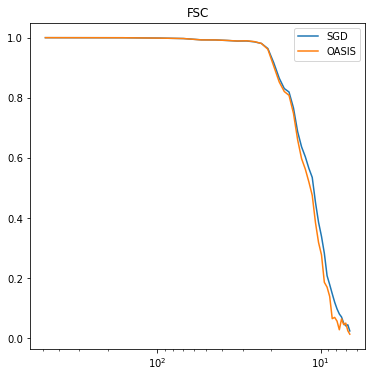

In [195]:
plt.semilogx(res_angs, fsc_sgd)
plt.semilogx(res_angs, fsc_o)
plt.gca().invert_xaxis()
plt.title("FSC")
plt.legend(["SGD", "OASIS"])

In [196]:
print(fsc_o[20])
print(fsc_o[21])
print(res_angs[20])
print(res_angs[16])

0.520568127607726
0.47593017036002644
11.806108919233715
14.668195929957037


In [197]:
# Just make sure that the loss at the starting points x01 and x02 is indeed larger than
# everything plotted

batch_sz = 100
n_batch = N//2 / batch_sz
idx_batches = np.array_split(np.arange(N//2), n_batch)

loss_x01 = 0
loss_x02 = 0
for idx in tqdm(idx_batches):
    loss_x01 += loss_func1(x01, idx)
    loss_x02 += loss_func2(x02, idx)
    
loss_x01 = loss_x01/n_batch                             
loss_x02 = loss_x02/n_batch 

print(f"loss1(x01) = {loss_x01}")
print(f"loss2(x02) = {loss_x02}")

100%|██████████| 400/400 [00:25<00:00, 15.55it/s]

loss1(x01) = 798034539.4603946
loss2(x02) = 796759693.918473


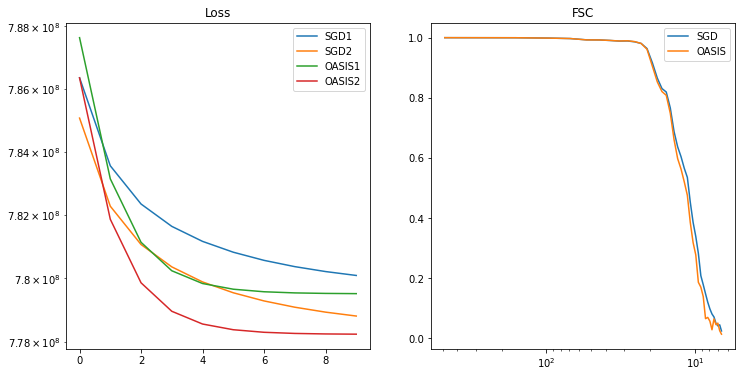

In [198]:
plt.rcParams["figure.figsize"]=12,6

plt.subplot(1,2,1)

plt.semilogy(loss_rec1)
plt.semilogy(loss_rec2)
plt.semilogy(loss_o1)
plt.semilogy(loss_o2)

#plt.semilogy(loss_x01 * np.ones((N_epochs,)))
#plt.semilogy(loss_x02 * np.ones((N_epochs,)))       

plt.title("Loss")
plt.legend(["SGD1", "SGD2", "OASIS1", "OASIS2"])

plt.subplot(1,2,2)

plt.semilogx(res_angs, fsc_sgd)
plt.semilogx(res_angs, fsc_o)
plt.gca().invert_xaxis()
plt.title("FSC")
plt.legend(["SGD", "OASIS"])

plt.rcParams["figure.figsize"]=6,6

#### Now the same with CG

In [70]:
N_iter = 20


In [ ]:
AA1, Ab1 = get_cg_vol_ops(gradv_obj.grad_loss_volume_sum, angles[idx1], shifts[idx1], ctf_params[idx1], imgs_f[idx1], v_rec1.shape, sigma_noise)
AA2, Ab2 = get_cg_vol_ops(gradv_obj.grad_loss_volume_sum, angles[idx2], shifts[idx2], ctf_params[idx2], imgs_f[idx2], v_rec1.shape, sigma_noise)


In [ ]:
v_rec_cg1, k1, v_rec_cg1_all = cg(AA1, Ab1, x01, N_iter, verbose=True)

In [ ]:
v_rec_cg2, k2, v_rec_cg2_all = cg(AA2, Ab2, x02, N_iter, verbose=True)

In [ ]:
loss_cg1 = jax.vmap(loss_func1, in_axes = (0, None))(jnp.array(v_rec_cg1_all), jnp.arange(N//2))
loss_cg2 = jax.vmap(loss_func2, in_axes = (0, None))(jnp.array(v_rec_cg2_all), jnp.arange(N//2))

In [ ]:
plt.plot(loss_rec1)
plt.plot(loss_rec2)
plt.plot(loss_o1)
plt.plot(loss_o2)
plt.plot(loss_cg1)
plt.plot(loss_cg2)
plt.legend(["SGD1", "SGD2", "OASIS1", "OASIS2", "CG1", "CG2"])


In [ ]:
plt.rcParams["figure.figsize"]=12, 12

plt.subplot(1,2,1)
mip_z(np.fft.fftshift(np.abs(v_rec_cg1))); plt.colorbar()

plt.subplot(1,2,2)
mip_z(np.fft.fftshift(np.abs(v_rec_cg2))); plt.colorbar()

In [ ]:
v_rec_cgl1, _ = rescale_larger_grid(v_rec_cg1, x_grid, nx0)
vr_cg1 = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(v_rec_cgl1)))

v_rec_cgl2, _ = rescale_larger_grid(v_rec_cg2, x_grid, nx0)
vr_cg2 = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(v_rec_cgl2)))

plt.subplot(1,2,1)
mip_z(vr_cg1)
#plt.colorbar()

plt.subplot(1,2,2)
mip_z(vr_cg2)
#plt.colorbar()

plt.rcParams["figure.figsize"]=6, 6


In [ ]:
with mrcfile.new(f"{out_dir}/v_rec_cg1.mrc", overwrite=True) as mrc:
    mrc.set_data(vr_cg1.astype(np.float32))
    
with mrcfile.new(f"{out_dir}/v_rec_cg2.mrc", overwrite=True) as mrc:
    mrc.set_data(vr_cg2.astype(np.float32))  

In [ ]:
res, fsc_cg, shell_points = calc_fsc(v_rec_cg1, v_rec_cg2, [1, nx_crop])
#res, fsc_cg, shell_points = calc_fsc(v_rec_cg1, v_rec2, [1, nx_crop])

res_angs = nx0 * pixel_size[0]/res
plt.semilogx(res_angs, fsc_cg)
plt.gca().invert_xaxis()
plt.title("FSC")

In [ ]:
fsc_cg

In [ ]:
loss1_x0 = loss_func1(x01, jnp.arange(N//2)) * jnp.ones((N_iter,))
loss2_x0 = loss_func2(x02, jnp.arange(N//2)) * jnp.ones((N_iter,))

In [ ]:
plt.rcParams["figure.figsize"]=12,6

plt.subplot(1,2,1)

plt.semilogy(loss_rec1)
plt.semilogy(loss_rec2)
plt.semilogy(loss_o1)
plt.semilogy(loss_o2)
plt.semilogy(loss_cg1)
plt.semilogy(loss_cg2)

#plt.semilogy(loss1_x0)
#plt.semilogy(loss2_x0)

plt.title("Loss")
plt.legend(["SGD1", "SGD2", "OASIS1", "OASIS2", "CG1", "CG2"])

plt.subplot(1,2,2)

plt.semilogx(res_angs, fsc_sgd)
plt.semilogx(res_angs, fsc_o)
plt.semilogx(res_angs, fsc_cg)
plt.gca().invert_xaxis()
plt.title("FSC")
plt.legend(["SGD", "OASIS", "CG"])

plt.rcParams["figure.figsize"]=6,6

In [ ]:
print(fsc_cg[15])
print(fsc_cg[16])
print(res_angs[15])
print(res_angs[16])

In [ ]:
print(loss_func1(v_rec1, jnp.arange(Nn)))
print(loss_func1(v_rec_o1, jnp.arange(Nn)))
print(loss_func1(v_rec_cg1, jnp.arange(Nn)))

In [ ]:
print(loss_func2(v_rec2, jnp.arange(Nn)))
print(loss_func2(v_rec_o2, jnp.arange(Nn)))
print(loss_func2(v_rec_cg2, jnp.arange(Nn)))

### Notes:

* It's important to use a large batch size for both SGD and OASIS: 1000 for 64-128px is good.
* OASIS rec with fixed rate is the same as SGD with D0 preconditioner,  the loss and results/FSC are almost identical (since here the Hessian doesn't depend on the current iterate and therefore is estimated perfectly at the beginning). -- actually not true in my latest experiments and I don't know why
* When using no $\sigma_{noise}$ with $128$ pixels and 40,000 images, both OASIS and SGD with precon required higher regularization parameter $10^{-5}$ compared to the other runs, where I used reg param $10^{-9}$
* I should with a dataset with no heterogeneity in the future
* Still don't know why the adaptive version fails

In [ ]:
pixel_size * 320/128

### Results:

Showing resolution cutoff at $FSC=0.5$ everywhere:

#### 1. Small data: `nx_crop=64px` and 10,000 images in each half set, 20 epochs (for SGD/OASIS) and 20 iters (for CG):

Everything here is with regularization parameter $10^{-9}$

Trilinear interpolation
* SGD no precon: $\approx 20 Å$ 
* SGD with precon: $\approx 20 Å$ 
* OASIS: $\approx 20 Å$ 
* OASIS adaptive: meh
* CG: $\approx 20 Å$ 

Nearest neighbour interpolation:

All $\approx 20 Å$ 


^ The FSC curves are almost identical for all

#### 2. Large data: `nx_crop=128px` and 40,000 images in each half set, 10 epochs:

Tri and NN, all around $\approx 14-15 Å$ 

# Figuring out the algorithm, running it on toy problem

### OASIS

#### Hutchinson's method

The diagonal of a symmetric matrix can be approximated as follows:

$
\text{diag}(A) = \mathbb{E}[z * Az ],
$

where $z$ is a random vector with Rademacher or Gaussian distribution and $*$ represents element-wise multiplication.

Here we're reproducing Figure 1 in the OASIS paper.

In [ ]:
n = 100

key = random.PRNGKey(int(jnp.floor(np.random.rand()*1000)))

In [ ]:
key, subkey = random.split(key)

A = random.normal(subkey, (n,n), dtype=jnp.complex128)
A = A.T + A

plt.imshow(jnp.real(A)); plt.colorbar()

In [ ]:
iters = 10000

key, subkey = random.split(key)
z = random.rademacher(subkey, (iters, n))

#z * A @ z 

In [ ]:
zAz = jax.vmap(lambda zi : zi * (A @ zi))(z)
#plt.imshow(zAz)

In [ ]:
d = np.zeros((iters, n), dtype=A.dtype)
d[0] = zAz[0]
for i in range(1, iters):
    d[i] = d[i-1] + zAz[i]
    
for i in range(1, iters):
    d[i] = d[i]/(i+1)

In [ ]:
err = jnp.mean((d - jnp.diag(A))**2, axis=1)

In [ ]:
plt.semilogy(jnp.abs(err))

#### Hessian-vector product in JaX

In [ ]:
key, *subkey = random.split(key, 4)
x0 = random.normal(subkey[0], (n,))
x = random.normal(subkey[1], (n,))
v = random.normal(subkey[2], (n,))

In [ ]:
b = A @ x0 
f = lambda x : jnp.real(jnp.mean(jnp.conj(A @ x - b)*(A@x-b)))

In [ ]:
from jax import jvp, grad

# Naive
def hvp0(f, x, v):
    return grad(lambda x : jnp.vdot(grad(f)(x), v))(x)

# forward-over-reverse
def hvp(f, x, v):
    return jvp(jax.grad(f), x, v)[1]

In [ ]:
%timeit hvp0(f, x, v)

%timeit hvp(f, (x,), (v,))

v1 = hvp0(f, x, v)
v2 = hvp(f, (x,), (v,))
jnp.sum(jnp.abs(v1-v2))

#### Toy problem

In [ ]:
key, *subkey = random.split(key, 3)

x_gt = random.normal(subkey[0], (n,), dtype=jnp.complex128)

A = random.normal(subkey[1], (n,n), dtype=x_gt.dtype)
A = A.T @ A
_, v = jnp.linalg.eigh(A)
d = jnp.flip(jnp.logspace(-5,1,n)) 
d = d + jnp.abs(jnp.min(d)*2)
A = v.T @ jnp.diag(d) @ v

evals, evecs = np.linalg.eig(A)
evals = np.flip(np.sort(evals))


assert(jnp.sum(evals < 0) == 0)
assert(jnp.max(jnp.imag(evals)) < 1e-13)
#assert(jnp.max(jnp.abs(A.T - A)) == 0)
#assert(jnp.sum(jnp.abs(A@A.T - A.T@ A)) == 0)

evals = jnp.real(evals)
plt.semilogy(evals, '.')
plt.title("Eigenvalues")
print(f"Condition number = {evals[0]/evals[n-1] : .2e}")

In [ ]:
sig_noise = 1
lam = 0.1

key, subkey = random.split(key)

b = A @ x_gt  + random.normal(subkey, (n,)) * sig_noise

F = jax.jit(lambda x : jnp.real(jnp.mean(jnp.conj(A @ x - b)*(A @ x - b)) + lam * jnp.mean(jnp.conj(x)*x)))
print(f"f(x_gt + 1) = {F(x_gt+1)}")
print(f"f(x_gt) = {F(x_gt)}")

gradF = jax.jit(jax.grad(F))
#hessianF = jax.hessian(F)

hvpF = jax.jit(lambda x, v : hvp(F, (x,), (v,)))

print(f"gradF(x_gt) = {gradF(x_gt)}")
#print(f"hessianF(x_gt) = {hessianF(x_gt)}")


In [ ]:
def gd(F, gradF, eta, w0, N_iter = 20, iter_display = 1):
    loss = []
    for k in range(1, N_iter+1):
        w1 = w0 - eta * jnp.conj(gradF(w0))
        loss_i = F(w1)
        loss.append(loss_i)
        
        w0 = w1
        
        if k % iter_display == 0:
            print(f"Iter {k}: loss = {loss_i}")
            
    return w1, jnp.array(loss)

def newton(F, gradF, hessianF, w0, N_iter = 20, iter_display = 1):
    loss = []
    for k in range(1, N_iter+1):
        G = gradF(w0)
        H = hessianF(w0)
        
        w1 = w0 - jnp.conj(jnp.linalg.inv(H) @ G)
        loss_i = F(w1)
        loss.append(loss_i)
        
        w0 = w1
        
        if k % iter_display == 0:
            print(f"Iter {k}: loss = {loss_i}")
            
    return w1, jnp.array(loss)

In [ ]:
N_iter = 1000
eta = 1e-3 #0.000005 # learning rate
x0 = np.random.randn(*x_gt.shape)

x_gd, loss_gd = gd(F, gradF, eta, x0, N_iter, iter_display = 200)

In [ ]:
plt.semilogy(loss_gd)

In [ ]:
#N_iter = 10

#x_n, loss_n = newton(F, gradF, hessianF, x0, N_iter, iter_display = 1)

In [ ]:
#plt.plot(loss_n)

In [ ]:
N_iter = 1000

zero = jnp.zeros(x_gt.shape)
Abfun = gradF(zero)

Ab = -jnp.conj(Abfun)
AA = jax.jit(lambda vv : jnp.conj(gradF(vv)) + Ab)

x_cg, kk, x_cg_all = cg(AA, Ab, x0, N_iter, verbose=True)
loss_cg = jax.vmap(F)(jnp.array(x_cg_all))

In [ ]:
print(F(x_gt))
print(F(x_cg))
print(F(x_gd))
#print(F(x_n))

#### OASIS

In [ ]:
Fidx = jax.jit(lambda x, idx : F(x))
gradFidx = jax.jit(lambda x, idx : jax.grad(F)(x))
hvpFidx = jax.jit(lambda x, v, idx : hvp(F, (x,), (v,)))

In [ ]:
# Estimating D0

iters = 100000
key, *subkeys = random.split(key, iters+1)
zD0z = np.zeros((n,))

for i in tqdm(range(iters)):
    z = random.rademacher(subkeys[i], (n,), dtype=x0.dtype)
    
    zD0z += z * hvpFidx(x0, z, 1)
    
D0 = jnp.array(zD0z/iters)

#D0exact = jnp.diag(hessianF(x0)) # Cheating a bit


In [ ]:
#plt.plot(jnp.abs(D0-D0exact)/jnp.abs(D0exact))

In [ ]:
N_iter = 1000
beta2 = 0.99
eta = 0.1 #0.1 #0.1/0.001/0.01/0.15
                       
alpha = 0.1 #0.1 # 0.01

key, subkey = random.split(key)
x_o, loss_o = oasis(subkey, Fidx, gradFidx, hvpFidx, x0, eta, D0, beta2, alpha, N_iter, iter_display = 100)


In [ ]:
N_iter = 1000
beta2 = 0.99
eta0 = 0.1 #0.1/0.001/0.01/0.15
                       
alpha = 0.1 # 0.01

key, subkey = random.split(key)
x_oa, loss_oa = oasis_adaptive(subkey, Fidx, gradFidx, hvpFidx, x0, eta0, D0, beta2, alpha, N_iter, iter_display = 500)


In [ ]:
#print(jnp.mean(jnp.abs(x_gt-x_n)))
print(jnp.mean(jnp.abs(x_gt-x_cg)))
print(jnp.mean(jnp.abs(x_gt-x_gd)))
print(jnp.mean(jnp.abs(x_gt-x_o)))
print(jnp.mean(jnp.abs(x_gt-x_oa)))

plt.rcParams["figure.figsize"]=12, 6

plt.subplot(1,2,1)

nn0 = 0
nn1 = 1000
#plt.semilogy(loss_n[nn0:nn1])
plt.semilogy(loss_gd[nn0:nn1])
plt.semilogy(loss_cg[nn0:nn1])
plt.semilogy(loss_o[nn0:nn1])
plt.semilogy(loss_oa[nn0:nn1])
#plt.legend(["Newton", "GD", "OASIS", "OASIS adaptive"])
plt.legend(["GD", "CG", "OASIS", "OASIS adaptive"])
plt.title("Loss")

plt.subplot(1,2,2)
#plt.semilogy(jnp.abs(x_gt-x_n))
plt.semilogy(jnp.abs(x_gt-x_gd))
plt.semilogy(jnp.abs(x_gt-x_o))
plt.semilogy(jnp.abs(x_gt-x_oa))
plt.legend(["GD", "OASIS", "OASIS_adaptive"])
plt.title("Error")

plt.rcParams["figure.figsize"]=6, 6

### Stochastic - sum of operators

In [ ]:
key = random.PRNGKey(int(jnp.floor(np.random.rand()*1000)))

Generate $N$ operators to create a loss function to run SGD/OASIS on:

In [ ]:
sig_noise = 10
lam = 0.1

In [ ]:
n = 100
N = 1000

key, subkey = random.split(key)

x_gt = random.normal(subkey, (n,), dtype=jnp.complex128)

ops = []
b = []
for i in range(N):
    key, *subkeys = random.split(key, 4)
    
    A = random.normal(subkeys[0], (n,n), dtype = x_gt.dtype)
    A = A.T @ A
    _, v = jnp.linalg.eigh(A)
    
    d = jnp.logspace(10,-5,n) + random.normal(subkeys[1], (n,), dtype = jnp.double)*10 
    d = d + jnp.abs(jnp.min(d)*2)
                 
    A = v.T @ jnp.diag(d) @ v
    ops.append(A)
    
    bn = A @ x_gt + random.normal(subkeys[2], (n,), dtype = x_gt.dtype) * sig_noise
    b.append(bn)
    
    #print(jnp.mean((A@x_gt - bn)**2))
    
ops = jnp.array(ops)
b = jnp.array(b)

In [ ]:
w, _ = jnp.linalg.eigh(A)
w = jnp.flip(jnp.sort(w))
print(f"{jnp.max(w)/jnp.min(w) : .2e}")

In [ ]:
print(jnp.max(w))
print(jnp.min(w))

In [ ]:
def loss_term(x, A, b):
    return 1/2 * jnp.real(jnp.mean(jnp.conj(A@x - b)*(A@x - b)) + lam * jnp.mean(jnp.conj(x)*x))

def loss_func(x, ops, b):
    return jnp.mean(jax.vmap(loss_term, in_axes = (None, 0, 0))(x, ops, b))

def grad_loss_func(x, ops, b):
    return jax.grad(loss_func)(x, ops, b)

def hvp_loss_func(x, v, ops, b):
    return jvp(lambda y : grad_loss_func(y, ops, b), (x,), (v,))[1]

In [ ]:
idx = np.random.permutation(N)[:N//3]

print(loss_term(x_gt, ops[0], b[0]))
print(loss_func(x_gt, ops, b))

print(grad_loss_func(x_gt, ops, b).shape)
print(grad_loss_func(x_gt, ops[idx], b[idx]).shape)

print(hvp_loss_func(x_gt, x_gt, ops, b).shape)
print(hvp_loss_func(x_gt, x_gt, ops[idx], b[idx]).shape)

In [ ]:
key, subkey = random.split(key)

hessianF = lambda x : jax.hessian(loss_func)(x, ops, b)

Fidx = jax.jit(lambda x, idx : loss_func(x, ops[idx], b[idx]))
gradFidx = jax.jit(lambda x, idx : grad_loss_func(x, ops[idx], b[idx]))
hvpFidx = jax.jit(lambda x, v, idx : hvp_loss_func(x, v, ops[idx], b[idx]))
x0 = random.normal(subkey, (n,), dtype = x_gt.dtype)

In [ ]:
Fidx(x_gt, jnp.arange(N))

In [ ]:
#D0 = jnp.ones((nx,nx,nx))  #<--- not very good
#D0exact = jnp.diag(hessianF(x0)) # This is cheating

iters = 10000
batch_sz = 32
key, *subkeys = random.split(key, 2*iters+1)

zD0z = np.zeros((n,))

for i in tqdm(range(iters)):
    z = random.rademacher(subkeys[2*i], (n,), dtype=x0.dtype)
    idx = random.permutation(subkeys[2*i+1], N)[:batch_sz]
    
    zD0z += z * hvpFidx(x0, z, idx)
    
D0 = jnp.array(zD0z/iters)


#plt.plot(jnp.abs(D0-D0exact)/jnp.abs(D0exact))

In [ ]:
N_epoch = 20
beta2 = 0.99
eta = 1e-1 #0.1 #0.1/0.001/0.01/0.15
                       
alpha = 0 #0.1 #0.1 # 0.01

key, subkey = random.split(key)
x_os, loss_os = oasis(subkey, Fidx, gradFidx, hvpFidx, x0, eta, D0, beta2, alpha, N_epoch, batch_size = 20, N = N, iter_display = 1)


In [ ]:
N_epoch = 20
beta2 = 0.99
eta = 0.01 #0.1 #0.1/0.001/0.01/0.15
                       
alpha = 0 #0.1 #0.1 # 0.01

key, subkey = random.split(key)
x_osa, loss_osa = oasis_adaptive(subkey, Fidx, gradFidx, hvpFidx, x0, eta, D0, beta2, alpha, N_epoch, batch_size = 20, N = N, iter_display = 1)


In [ ]:
N_epoch = 20
beta2 = 0.99
eta = 1e-1 #0.1 #0.1/0.001/0.01/0.15
                       
alpha = 0 #0.1 #0.1 # 0.01

key, subkey = random.split(key)
x_o, loss_o = oasis(subkey, Fidx, gradFidx, hvpFidx, x0, eta, D0, beta2, alpha, N_epoch, batch_size = None, N=N, iter_display = 1)

In [ ]:
N_epoch = 20
beta2 = 0.99
eta = 1e-1 #0.1 #0.1/0.001/0.01/0.15
                       
alpha = 0 #0.1 #0.1 # 0.01

key, subkey = random.split(key)
x_oa, loss_oa = oasis_adaptive(subkey, Fidx, gradFidx, hvpFidx, x0, eta, D0, beta2, alpha, N_epoch, batch_size = None, N=N, iter_display = 1)


In [ ]:
N_epoch = 20
eta = 1e-18
                       
key, subkey = random.split(key)
x_sgd, loss_sgd, _ = sgd(gradFidx, Fidx, N, x0, eta, N_epoch, batch_size = 20, verbose = True, iter_display = 1)

In [ ]:
N_epoch = 20
beta2 = 0.99
eta = 1e-1
                       
key, subkey = random.split(key)
x_sgdp, loss_sgdp, _ = sgd(gradFidx, Fidx, N, x0, eta, N_epoch, batch_size = 20, P = 1/D0, verbose = True, iter_display = 1)

In [ ]:
plt.rcParams["figure.figsize"]=12, 6

plt.subplot(1,2,1)
plt.semilogy(loss_sgd)
plt.semilogy(loss_sgdp)
plt.semilogy(loss_o)
plt.semilogy(loss_os)
plt.semilogy(loss_oa)
plt.semilogy(loss_osa)
plt.legend(["SGD", "SGD precon", "OASIS fixed rate, deterministic", "OASIS fixed_rate, stochastic", "OASIS adaptive, deterministic", "OASIS adaptive, stochastic"])
#plt.legend(["SGD", "OASIS fixed_rate, stochastic", "OASIS adaptive, stochastic"])
plt.title("Loss")

plt.subplot(1,2,2)
plt.semilogy(jnp.abs(x_sgd-x_gt))
plt.semilogy(jnp.abs(x_sgdp-x_gt))
#plt.semilogy(jnp.abs(x_o-x_gt))
plt.semilogy(jnp.abs(x_os-x_gt))
#plt.semilogy(jnp.abs(x_oa-x_gt))
plt.semilogy(jnp.abs(x_osa-x_gt))
#plt.legend(["SGD", "OASIS fixed rate, deterministic", "OASIS fixed_rate, stochastic", "OASIS adaptive, deterministic", "OASIS adaptive, stochastic"])
plt.legend(["SGD", "SGD+p", "OASIS fixed_rate, stochastic", "OASIS adaptive, stochastic"])
plt.title("Error")

plt.rcParams["figure.figsize"]=6,6

In [ ]:
plt.semilogy(loss_sgdp)
plt.semilogy(loss_os)
plt.legend(["Loss SGD+precon", "Loss OASIS stochastic"])

In [ ]:
print(Fidx(x_gt, jnp.arange(N)))
print(Fidx(x_sgd, jnp.arange(N)))
print(Fidx(x_sgdp, jnp.arange(N)))
print(Fidx(x_o, jnp.arange(N)))
print(Fidx(x_os, jnp.arange(N)))
print(Fidx(x_oa, jnp.arange(N)))
print(Fidx(x_osa, jnp.arange(N)))


Next:

* ~~Run the new OASIS algorithms on the old (deterministic one operator) toy problem~~
* ~~Implement the adaptive version of the stochastic OASIS~~
* ~~Add noise and rerun all the experiments~~
* In the stochastic toy problem case, also compare with CG (make the problem small enough so that we can do CG)
* ~~Implement some kind of warm up /estimation of $D_0$~~
* ~~Run on CryoEM data~~